In [1]:
# import
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [49]:
# Constants to be tuned
SHORT_WINDOW = 5
LONG_WINDOW = 60
RSI_BUY_SIGNAL = 45
RSI_SELL_SIGNAL = 70
RSI_WINDOW = 60

In [3]:
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data["Volume_Series"] = stock_data["Volume"][ticker]
    return stock_data

In [4]:
def calculate_moving_average(data, window):
    return data['Close'].rolling(window=window).mean()

In [5]:
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
def get_market_exit_signal(index_data, long_term_ma):
    index_data['Long_Term_MA'] = index_data['Close'].rolling(window=long_term_ma).mean()
    if index_data['Close'].iloc[-1] < index_data['Long_Term_MA'].iloc[-1]:
        return "Exit Market"
    return "Stay"
def check_buy_signal(stock_data, short_window, long_window, rsi_buy_signal, rsi_window):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for buy signal
    buy_signal = (stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1]) and \
                 (stock_data['RSI'].iloc[-1] < rsi_buy_signal) and \
                 (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return buy_signal, stock_data

def check_sell_signal(stock_data, short_window, long_window, rsi_sell_signal, rsi_window):
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume'].rolling(window=short_window).mean()

    # Check the latest data point for sell signal
    sell_signal = (stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]) and \
                  (stock_data['RSI'].iloc[-1] > rsi_sell_signal) and \
                  (stock_data['Volume'].iloc[-1] > stock_data['Volume_MA'].iloc[-1])
    return sell_signal, stock_data

In [7]:
def decide_trade(stock_data, short_window, long_window, rsi_buy_signal, rsi_sell_signal, rsi_window):
    print("short_window: ", short_window)
    print("long_window: ", long_window)
    print("rsi_buy_signal: ", rsi_buy_signal)
    print("rsi_sell_signal: ", rsi_sell_signal)
    print("rsi_window: ", rsi_window)
    stock_data['Short_MA'] = calculate_moving_average(stock_data, short_window)
    stock_data['Long_MA'] = calculate_moving_average(stock_data, long_window)
    stock_data['RSI'] = calculate_rsi(stock_data, rsi_window)
    stock_data['Volume_MA'] = stock_data['Volume_Series'].rolling(window=short_window).mean()

    buy_signals = ((stock_data['Short_MA'] < stock_data['Long_MA']) & (stock_data['RSI'] < rsi_buy_signal)) & (stock_data['Volume_Series'] > stock_data['Volume_MA'])
    sell_signals = ((stock_data['Short_MA'] > stock_data['Long_MA']) & (stock_data['RSI'] > rsi_sell_signal)) & (stock_data['Volume_Series'] > stock_data['Volume_MA'])
    
    return buy_signals, sell_signals

In [8]:
def recommended_pe_ratio(sector):
    pe_ratios = {
        'Technology': (25, 35),
        'Utilities': (10, 20),
        'Consumer Discretionary': (15, 25),
        'Healthcare': (15, 25),
        'Pharmaceuticals': (15, 25),
        'Financial': (10, 15),
        'Energy': (5, 15),
        'Industrials': (15, 25),
        'Materials': (15, 25),
        'Real Estate': (15, 25),
        'Telecommunication': (10, 15),
        'Consumer Staples': (20, 25),
        'Information Technology': (25, 35)
    }
    
    return pe_ratios.get(sector, ('N/A', 'N/A'))  # Default to 'N/A' if the sector is not listed

# Example usage
sector = 'Technology'
print(f"Recommended P/E Ratio for {sector}: {recommended_pe_ratio(sector)}")

Recommended P/E Ratio for Technology: (25, 35)



# Backtest

In [33]:
def backtest_strategy(stock_data, buy_signals, sell_signals, holding_period=30, investment_fraction=0.1):
    initial_balance = 10000  # Example starting balance
    balance = initial_balance
    position = 0
    purchase_price = 0  # To track the purchase price of the stock
    holding_start_date = None  # To track when a stock is bought
    trade_history = []

    for i in range(len(stock_data)):
        current_date = stock_data.index[i]
        current_price = stock_data['Close'][i]

        if buy_signals[i] and balance >= current_price:
            # Buy - use only a fraction of the available balance
            investment_amount = balance * investment_fraction
            shares_to_buy = investment_amount // current_price
            if shares_to_buy > 0:  # Ensuring we have enough balance to buy at least one share
                balance -= shares_to_buy * current_price
                position += shares_to_buy
                purchase_price = current_price
                holding_start_date = current_date
                trade_history.append(('BUY', current_date, current_price, shares_to_buy))

        elif sell_signals[i] and position > 0:
            days_held = (current_date - holding_start_date).days if holding_start_date else 0
            is_profit = current_price > purchase_price

            # Sell if held for at least 30 days or at a loss
            if days_held >= holding_period or not is_profit:
                balance += position * current_price
                trade_history.append(('SELL', current_date, current_price, position))
                position = 0
                holding_start_date = None
                purchase_price = 0

    final_balance = balance + (position * stock_data['Close'].iloc[-1])
    total_return = final_balance - initial_balance
    return_percentage = (total_return / initial_balance) * 100

    return trade_history, total_return, return_percentage

[*********************100%***********************]  1 of 1 completed

Analyzing VOO...
short_window:  5
long_window:  60
rsi_buy_signal:  45
rsi_sell_signal:  70
rsi_window:  60
Buy signals for VOO:
 Price            Close        High         Low        Open    Volume  \
Ticker             VOO         VOO         VOO         VOO       VOO   
Date                                                                   
2023-09-26  384.601746  388.126944  383.818345  387.500253   5734700   
2023-10-03  380.790405  385.253040  379.453559  383.926033   6886700   
2023-10-11  394.099731  394.257009  391.209815  393.450972   4181800   
2023-10-12  391.730835  394.954956  389.450381  394.640430   3872900   
2023-10-13  389.666626  394.129261  388.231477  392.998859   3769800   
2023-10-18  388.487000  392.998800  387.504036  392.094490   7329300   
2023-10-19  385.194122  390.826517  384.476578  389.224281   6708900   
2023-10-20  380.397247  385.144980  380.249809  384.712474   7546900   
2023-10-26  372.543365  376.868401  371.707840  376.111530   6959400   
2023-1

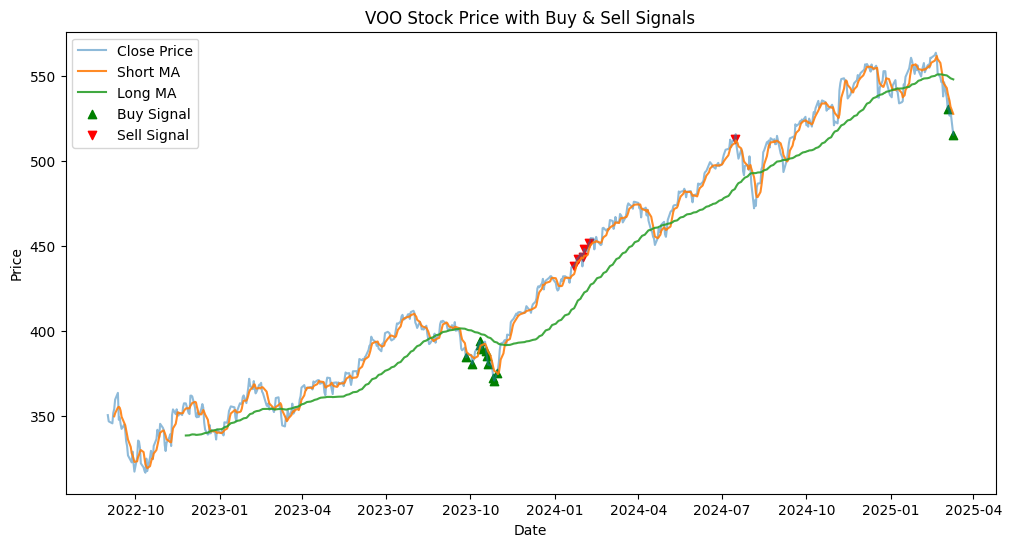

[*********************100%***********************]  1 of 1 completed

Analyzing AMD...
short_window:  5
long_window:  60
rsi_buy_signal:  45
rsi_sell_signal:  70
rsi_window:  60
Buy signals for AMD:
 Price            Close        High         Low        Open     Volume  \
Ticker             AMD         AMD         AMD         AMD        AMD   
Date                                                                    
2023-08-23  109.430000  110.080002  105.000000  105.650002   54656300   
2023-08-24  101.800003  111.639999  100.870003  111.059998  109179100   
2023-08-25  102.250000  104.120003   99.580002  101.169998   74793100   
2023-09-21   96.110001   98.870003   95.839996   98.599998   59628600   
2023-09-22   96.199997   98.419998   95.610001   96.919998   52169400   
2023-09-27   98.070000   99.230003   96.349998   96.820000   51261500   
2023-10-27   96.430000   97.349998   94.589996   95.800003   52458700   
2023-10-31   98.500000   98.820000   94.070000   96.239998   79547100   
2024-04-19  146.639999  154.250000  145.289993  151.589996   712325

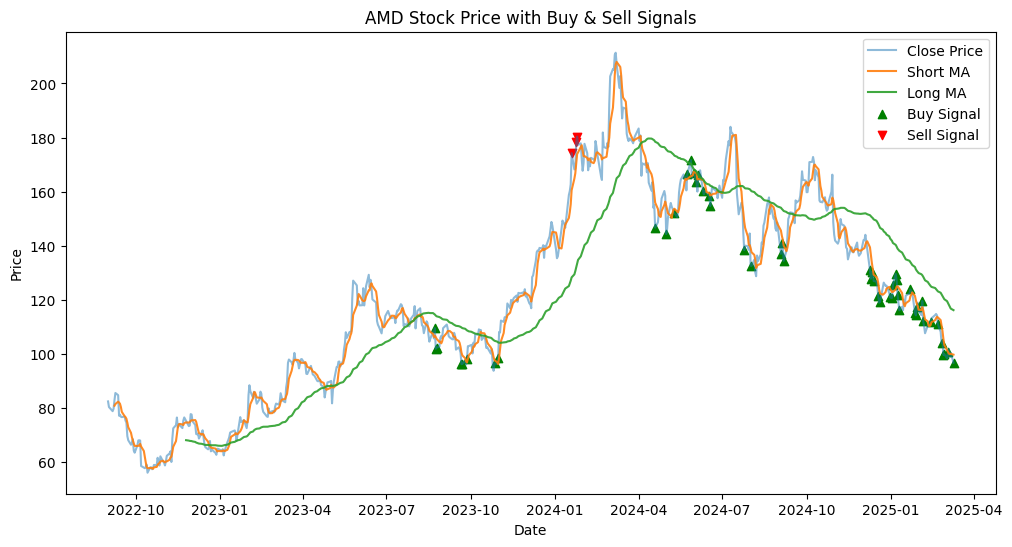

[*********************100%***********************]  1 of 1 completed

Analyzing SMCI...
short_window:  5
long_window:  60
rsi_buy_signal:  45
rsi_sell_signal:  70
rsi_window:  60
Buy signals for SMCI:
 Price           Close       High        Low       Open     Volume  \
Ticker           SMCI       SMCI       SMCI       SMCI       SMCI   
Date                                                                
2023-10-26  23.945999  25.334999  23.466999  25.238001   31039000   
2023-10-30  23.662001  24.830999  23.287001  24.584999   26313000   
2023-11-01  25.226999  25.400000  24.121000  24.129999   38150000   
2024-05-31  78.450996  81.964996  76.000999  81.599998   74080000   
2024-06-03  77.058998  80.605003  74.122002  80.199997   61558000   
2024-06-05  80.251999  82.253998  78.017998  79.500000   63075000   
2024-06-10  78.685997  80.400002  75.303001  76.165001   48790000   
2024-06-12  77.473999  80.135002  76.615997  78.500000   41190000   
2024-07-25  69.560997  72.050003  66.320000  69.999001   70478000   
2024-08-01  67.223999  72.445000  65.858

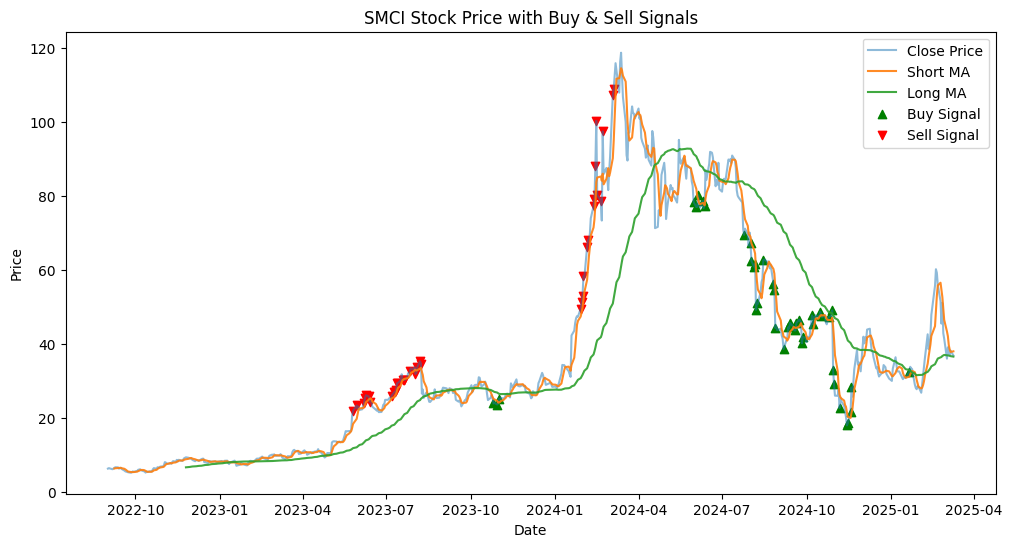

In [50]:

# # Define a list of stock tickers
tickers = ['VOO', 'AMD', 'SMCI']
# tickers = ['BABA','PDD','ARM','BTC-USD', 'ETH-USD','NVDA','SMCI','AMC','META','SAVE','LLY', 'BAC','SHOP']
# tickers = ['META', 'GOOG', 'AAPL', 'NVDA', 'BTC-USD','PDD','AMC']
start_date = '2022-09-01'
end_date = '2025-03-11'

# Monitor each stock
# Monitor each stock
for ticker in tickers:
    print(f"Analyzing {ticker}...")
    stock = get_stock_data(ticker, start_date, end_date)
    buy, sell = decide_trade(stock, short_window=SHORT_WINDOW, long_window=LONG_WINDOW, rsi_buy_signal=RSI_BUY_SIGNAL, rsi_sell_signal=RSI_SELL_SIGNAL, rsi_window=RSI_WINDOW )
    print(f"Buy signals for {ticker}:\n", stock[buy])
    print(f"Sell signals for {ticker}:\n", stock[sell])

    # Optional: Plotting
    plt.figure(figsize=(12,6))
    plt.plot(stock['Close'], label='Close Price', alpha=0.5)
    plt.plot(stock['Short_MA'], label='Short MA', alpha=0.9)
    plt.plot(stock['Long_MA'], label='Long MA', alpha=0.9)
    plt.scatter(stock.index[buy], stock['Close'][buy], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(stock.index[sell], stock['Close'][sell], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.title(f'{ticker} Stock Price with Buy & Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()


In [11]:

# # Example usage
# for ticker in tickers:
#   stock = get_stock_data(ticker, start_date, end_date)
#   buy, sell = decide_trade(stock, short_window=5, long_window=20, rsi_buy_signal= 30, rsi_sell_signal=90)
#   trades, total_return, return_percentage = backtest_strategy(stock, buy, sell,30,0.1)
#   print(f"#######################{ticker}##########################")
#   print(f"Trades: {trades}")
#   print(f"Total Return: ${total_return:.2f}")
#   print(f"Return Percentage: {return_percentage:.2f}%")
#   print(f"Hold Return Percentage: {(stock['Close'][len(stock)-1]-stock['Close'][0])/stock['Close'][0]*100:.2f}%")


In [12]:
def get_stock_info_on_date(tickers, short_window, long_window, rsi_buy_signal, rsi_sell_signal, rsi_window, date=datetime.today().strftime("%Y-%m-%d"), history_days=600, long_term_ma=200):
    print("Today is " + date)
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=history_days)

    # market_index = yf.Ticker("^GSPC")  # S&P 500 Index
    # market_data = market_index.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    # market_signal = get_market_exit_signal(market_data, long_term_ma)
    # print(market_signal)

    data = {'Company Code': [], 'Date': [], 'Daily Price': [], 'Recommendation': [],'60 DAY RSI':[], 'P/E Ratio': [], 'Recommended PE':[], 'Category': [],'Dividend Yield': [], 'Market Cap': [], 'Earnings Growth': [], 'One Year Target': [], 'Analyst Buy': [], 'Analyst Hold': [], 'Analyst Sell': []}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        hist_data = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
        if hist_data.empty:
            continue  # Skip if no data for the given date range
        
        last_date = hist_data.index[-1].strftime('%Y-%m-%d')  # Last date in the historical data
        daily_price = hist_data['Close'].iloc[-1]  # Last close price
        # Apply buy/sell signal functions (as previously defined)
        risk_buy_signal, buy_data = check_buy_signal(hist_data, short_window=short_window, long_window=long_window, rsi_buy_signal=rsi_buy_signal, rsi_window=rsi_window)
        buy_signal, _ = check_buy_signal(hist_data, short_window=short_window, long_window=long_window, rsi_buy_signal=rsi_buy_signal, rsi_window=rsi_window)
        sell_signal, _ = check_sell_signal(hist_data, short_window=short_window, long_window=long_window, rsi_sell_signal=rsi_sell_signal, rsi_window=rsi_window)
        recommendation = 'BUY' if buy_signal else 'SELL' if sell_signal else 'RISK BUY' if risk_buy_signal else None

        if recommendation:
            pe_ratio = stock.info.get('trailingPE', 'N/A')
            category = stock.info.get('sector', 'N/A')
            dividend_yield = stock.info.get('dividendYield', 'N/A') * 100 if stock.info.get('dividendYield') is not None else 'N/A'
            market_cap = stock.info.get('marketCap', 'N/A')
            earnings_growth = stock.info.get('earningsGrowth', 'N/A')
            one_year_target = stock.info.get('targetMeanPrice')
            analyst_buy_ratings = stock.info.get('buyRatingCount')
            analyst_hold_ratings = stock.info.get('holdRatingCount')
            analyst_sell_ratings = stock.info.get('sellRatingCount')
            data['Company Code'].append(ticker)
            data['Recommendation'].append(recommendation)
            data['60 DAY RSI'].append(buy_data['RSI'].iloc[-1])
            data['P/E Ratio'].append(pe_ratio)
            data['Category'].append(category)
            data['Dividend Yield'].append(dividend_yield)
            data['Market Cap'].append(market_cap)
            data['Earnings Growth'].append(earnings_growth)
            data['Recommended PE'].append(recommended_pe_ratio(category))
            data['One Year Target'].append(one_year_target)
            data['Analyst Buy'].append(analyst_buy_ratings)
            data['Analyst Hold'].append(analyst_hold_ratings)
            data['Analyst Sell'].append(analyst_sell_ratings)
            data['Date'].append(last_date)
            data['Daily Price'].append(daily_price)

    return pd.DataFrame(data)


In [13]:
def get_sp500_tickers():
    # url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    # sp500_table = pd.read_html(url, header=0)[0]
    # tickers = sp500_table['Symbol'].tolist()
    # print(tickers)
    # return tickers
    return ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DE', 'DAL', 'XRAY', 'DVN', 'DXCM', 'FANG', 'DLR', 'DFS', 'DG', 'DLTR', 'D', 'DPZ', 'DOV', 'DOW', 'DHI', 'DTE', 'DUK', 'DD', 'EMN', 'ETN', 'EBAY', 'ECL', 'EIX', 'EW', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'ETR', 'EOG', 'EPAM', 'EQT', 'EFX', 'EQIX', 'EQR', 'ESS', 'EL', 'ETSY', 'EG', 'EVRG', 'ES', 'EXC', 'EXPE', 'EXPD', 'EXR', 'XOM', 'FFIV', 'FDS', 'FICO', 'FAST', 'FRT', 'FDX', 'FIS', 'FITB', 'FSLR', 'FE', 'FI', 'FLT', 'FMC', 'F', 'FTNT', 'FTV', 'FOXA', 'FOX', 'BEN', 'FCX', 'GRMN', 'IT', 'GEHC', 'GEN', 'GNRC', 'GD', 'GE', 'GIS', 'GM', 'GPC', 'GILD', 'GPN', 'GL', 'GS', 'HAL', 'HIG', 'HAS', 'HCA', 'PEAK', 'HSIC', 'HSY', 'HES', 'HPE', 'HLT', 'HOLX', 'HD', 'HON', 'HRL', 'HST', 'HWM', 'HPQ', 'HUBB', 'HUM', 'HBAN', 'HII', 'IBM', 'IEX', 'IDXX', 'ITW', 'ILMN', 'INCY', 'IR', 'PODD', 'INTC', 'ICE', 'IFF', 'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'INVH', 'IQV', 'IRM', 'JBHT', 'JBL', 'JKHY', 'J', 'JNJ', 'JCI', 'JPM', 'JNPR', 'K', 'KVUE', 'KDP', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LDOS', 'LEN', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LULU', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MTCH', 'MKC', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MRNA', 'MHK', 'MOH', 'TAP', 'MDLZ', 'MPWR', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'NDAQ', 'NTAP', 'NFLX', 'NEM', 'NWSA', 'NWS', 'NEE', 'NKE', 'NI', 'NDSN', 'NSC', 'NTRS', 'NOC', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'NXPI', 'ORLY', 'OXY', 'ODFL', 'OMC', 'ON', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PANW', 'PARA', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PTC', 'PSA', 'PHM', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RVTY', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SJM', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STLD', 'STE', 'SYK', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TRGP', 'TGT', 'TEL', 'TDY', 'TFX', 'TER', 'TSLA', 'TXN', 'TXT', 'TMO', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TRMB', 'TFC', 'TYL', 'TSN', 'USB', 'UBER', 'UDR', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'UHS', 'VLO', 'VTR', 'VLTO', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VFC', 'VTRS', 'VICI', 'V', 'VMC', 'WRB', 'WAB', 'WBA', 'WMT', 'DIS', 'WBD', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WRK', 'WY', 'WHR', 'WMB', 'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']

sp500_tickers = get_sp500_tickers()

In [14]:
def get_nasdaq_tickers():
    # url = 'https://en.wikipedia.org/wiki/NASDAQ-100'
    # tables = pd.read_html(url)  # Scrapes all tables from the Wikipedia page
    # nasdaq_table = tables[4]  # The table with NASDAQ tickers is typically the fourth table on the page
    # nasdaq_tickers = nasdaq_table['Ticker'].tolist()  # Extracts the tickers into a list
    # return nasdaq_tickers
    return ['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']

nasdaq_tickers = get_nasdaq_tickers()
print(nasdaq_tickers)

['ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG', 'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH', 'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL', 'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD', 'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO', 'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']


# Useless Stock Filter

In [15]:
# # Rules
# def rule_price_above_moving_averages(stock_data):
#     """Price and 50-day MA higher than both 150-day and 200-day MAs."""
#     ma50 = stock_data['Close'].rolling(window=50).mean()
#     ma150 = stock_data['Close'].rolling(window=150).mean()
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price)
#     # print(ma50.iloc[-1])
#     # print(ma150.iloc[-1])
#     # print(ma200.iloc[-1])
#     # print(current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1])
#     return current_price > ma150.iloc[-1] and current_price > ma200.iloc[-1] and ma50.iloc[-1] > ma150.iloc[-1] and ma50.iloc[-1] > ma200.iloc[-1]

# def rule_ma200_uptrend(stock_data, days=30):
#     """200-day MA has been in an uptrend for at least 'days' days."""
#     ma200 = stock_data['Close'].rolling(window=200).mean()
#     # for every ten days, check if it is still the trend
#     for i in range(-1, -days, -10):
#         # print(ma200.iloc[-10*i-1],ma200.iloc[-10*i+9])
#         if ma200.iloc[-10*i-1] >= ma200.iloc[-10*i+9]:
#             return False
#     # print(ma200.iloc[-1] > ma200.iloc[-days])
#     return True 
#     # return ma200.iloc[-1] > ma200.iloc[-days]

# def rule_price_above_52week_low(stock_data, threshold=0.25):
#     """Current price is at least 'threshold' % higher than the 52-week low."""
#     low_52week = stock_data['Close'].rolling(window=252).min().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= low_52week * (1 + threshold))
#     return current_price >= low_52week * (1 + threshold)

# def rule_price_near_52week_high(stock_data, threshold=0.25):
#     """Current price is within 'threshold' % of the 52-week high."""
#     high_52week = stock_data['Close'].rolling(window=252).max().iloc[-1]
#     current_price = stock_data['Close'].iloc[-1]
#     # print(current_price >= high_52week * (1 - threshold))
#     return current_price >= high_52week * (1 - threshold)

In [16]:
# def stock_filter(tickers, rules,date = datetime.today().strftime("%Y-%m-%d")):
#     filtered_stocks = []
#     for ticker in tickers:
#         end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
#         min_history_days = 3*365
#         start_date = end_date - timedelta(days=min_history_days)
#         try:
#             data = yf.download(ticker, start=start_date, end=date, progress=False)
#             if all(rule(data) for rule in rules):
#                 filtered_stocks.append(ticker)
#             # else:
#                 # print(ticker + ' is not recommended to trade')
#         except:
#             continue
#     return filtered_stocks

In [17]:
# filter_rules = [
#     rule_price_above_moving_averages,
#     rule_ma200_uptrend,
#     rule_price_above_52week_low,
#     rule_price_near_52week_high
# ]

# # List of tickers
# # tickers = ['AAPL','AMD','ARKK','ARM','BA', 'BABA','BAC','BILI','BNTX', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DDOG', 'DIS', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'MDB','META', 'MSFT', 'NKE', 'NVDA', 'ORCL', 'OXY', 'PDD', 'PLTR', 'RBLX', 'SAVE', 'SHOP', 'SNOW', 'SOFI', 'TMF', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'WFC','XOM']
# tickers = nasdaq_tickers
# tickers.append(sp500_tickers)
# # tickers=['AAPL',"NVDA","TSLA","MSFT","COIN"]
# # tickers = ['NVDA']
# # Apply the filter
# filtered_stocks = stock_filter(tickers, filter_rules)
# print("Stocks that meet the criteria:", filtered_stocks)

In [18]:
# def test_stock_filter_performance(tickers, rules, start_date, end_date):
#     passed_stocks = stock_filter(tickers, rules, start_date)
#     failed_stocks = set(tickers) - set(passed_stocks)

#     return calculate_average_return(passed_stocks, start_date, end_date), calculate_average_return(failed_stocks, start_date, end_date), passed_stocks, failed_stocks

# def calculate_average_return(stocks, start_date, end_date):
#     returns = []
#     annualized_returns = []
#     start = datetime.strptime(start_date, '%Y-%m-%d')
#     end = datetime.strptime(end_date, '%Y-%m-%d')
#     days_in_period = (end - start).days
#     for ticker in stocks:
#         try:
#             stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
#             if not stock_data.empty:
#                 initial_price = stock_data['Close'].iloc[0]
#                 final_price = stock_data['Close'].iloc[-1]
#                 stock_return = (final_price - initial_price) / initial_price
#                 annualized_return = (1 + stock_return) ** (365.0 / days_in_period) - 1
#                 returns.append(stock_return)
#                 annualized_returns.append(annualized_return)
#         except:
#             continue
#     if returns:
#         return sum(returns) / len(returns), sum(annualized_returns)/len(annualized_returns)
#     else:
#         # need a better solution
#         return 0, 0

# # Example usage
# tickers = sp500_tickers
# start_date = "2023-01-01"
# end_date = '2023-12-01'

# average_return_passed, average_return_failed, passed_stocks, failed_stocks = test_stock_filter_performance(tickers, filter_rules, start_date, end_date)
# print("Average yearly Return of Passed Stocks:", average_return_passed[1], "Number of Passed Stocks: ", len(passed_stocks))
# print(passed_stocks)
# print("Average yearly Return of Failed Stocks:", average_return_failed[1], "Number of Failed Stocks: ", len(failed_stocks))

In [19]:

# def closest_trading_date(data, date):
#     """Find the closest previous trading date in the data for a given date."""
#     if date in data.index:
#         return date
#     # Iterate backwards to find the closest previous date
#     while date not in data.index:
#         date -= pd.Timedelta(days=1)
#     return date

# def test_filter_performance_over_periods(tickers, rules, start_date, end_date):
  
#     # Generate dates at regular intervals between start and end
#     date_range = pd.date_range(start=start_date, end=end_date, freq='M')
#     filtered_stocks = stock_filter(tickers, rules, start_date)
#     unfiltered_stocks = set(tickers) - set(filtered_stocks)

#     # Lists to store results
#     filtered_returns = []
#     unfiltered_returns = []
#     differences = []
#     sp500_returns = []

#     sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)['Close']
    
#     for date in date_range:
#         trading_date = closest_trading_date(sp500, date)

#         filtered_avg_return, _ = calculate_average_return(filtered_stocks, start_date, date.strftime('%Y-%m-%d'))
#         unfiltered_avg_return, _ = calculate_average_return(unfiltered_stocks, start_date, date.strftime('%Y-%m-%d'))

#         sp500_return = (sp500.loc[trading_date] - sp500[0]) / sp500[0]

#         filtered_returns.append(filtered_avg_return if filtered_avg_return is not None else 0)
#         unfiltered_returns.append(unfiltered_avg_return if unfiltered_avg_return is not None else 0)
#         differences.append((filtered_avg_return - unfiltered_avg_return) if filtered_avg_return is not None and unfiltered_avg_return is not None else 0)
#         sp500_returns.append(sp500_return)

#     return date_range, filtered_returns, unfiltered_returns, differences, sp500_returns


# start_date = '2022-05-01'
# end_date = '2024-01-01'
# tickers = nasdaq_tickers[30:70]
# date_range, filtered_returns, unfiltered_returns, differences, sp500_returns = test_filter_performance_over_periods(tickers, filter_rules, start_date, end_date)


In [20]:
# plt.figure(figsize=(12, 6))
# plt.plot(date_range, filtered_returns, label='Filtered Stocks')
# plt.plot(date_range, unfiltered_returns, label='Unfiltered Stocks')
# plt.plot(date_range, differences, label='Difference (Filtered - Unfiltered)')
# plt.plot(date_range, sp500_returns, label='S&P 500', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('Average Return')
# plt.title('Performance Comparison Over Time')
# plt.legend()
# plt.grid(True)
# plt.show()


# Stock Warning

In [21]:
def rule_price_increase(stock_data):
    """Rule 2: 25-50% increase in 1 to 3 weeks."""
    period_returns = stock_data['Close'].pct_change(periods=5).iloc[-1]  # 1-week return
    return 0.25 <= period_returns <= 0.50

def rule_largest_gain(stock_data):
    """Rule 3: Largest single-day gain since rise began."""
    daily_gains = stock_data['Close'].pct_change()
    max_gain = daily_gains.max()
    recent_gain = daily_gains.iloc[-1]
    return recent_gain == max_gain

def rule_accelerating_growth(stock_data):
    """Rule 6: 6-10 days of accelerating growth, with only about 2 days of decline."""
    recent_data = stock_data['Close'].iloc[-10:]
    up_days = recent_data.pct_change() > 0
    return up_days.sum() >= 8

def rule_falling_below_ma(stock_data):
    """Rule 10: Falling below 50-day MA on largest volume."""
    ma50 = stock_data['Close'].rolling(window=50).mean().iloc[-1]
    max_volume = stock_data['Volume'].max()
    recent_volume = stock_data['Volume'].iloc[-1]
    current_price = stock_data['Close'].iloc[-1]
    return current_price < ma50 and recent_volume == max_volume

In [22]:
def stock_warning_system(tickers, date, rules):
    warnings = {}
    end_date = datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)  # To include the end date in the fetch
    start_date = end_date - timedelta(days=365)
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=date)
        for rule in rules:
            if rule(data):
                warnings.setdefault(ticker, []).append(rule.__name__)
    return warnings

In [23]:
# # Define your rules
# warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]  # Add other rule functions here

# # List of tickers and a specific date
# # tickers = ['AAPL', 'MSFT', 'GOOG']
# tickers = nasdaq_tickers
# date = '2024-01-03'  # Replace with your date

# # Get warnings 
# warnings = stock_warning_system(tickers, date, warning_rules)
# print("Warnings:", warnings)

## Earnings

In [24]:
def upcoming_earnings(tickers, reference_date, within_days=10):
    reference_date = datetime.strptime(reference_date, '%Y-%m-%d')
    days_later = reference_date + timedelta(days=within_days)
    earnings_list = []

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try:
            info = stock.info
            if 'earningsQuarterlyGrowth' not in info: # filter out etfs
                continue
            earnings_data = stock.calendar
            if earnings_data and 'Earnings Date' in earnings_data:
                if len(earnings_data['Earnings Date']) > 0:
                    earnings_date = earnings_data['Earnings Date'][0]
                    earnings_date = pd.to_datetime(earnings_date).to_pydatetime()
                    if reference_date <= earnings_date < days_later:
                        earnings_list.append((ticker, earnings_date))
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")

    # Sort the list by earnings date
    earnings_list.sort(key=lambda x: x[1])
    return earnings_list

# Example usage
# tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN']  # Replace with your list of tickers
# date = '2024-01-24'  # Replace with your reference date

# stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
# for ticker, earnings_date in stocks_with_upcoming_earnings:
#     print(f"{ticker}: Earnings on {earnings_date}")


# Candlestick Pattern detection function

In [25]:
# def is_bullish_engulfing(data):
#     # Check if the last two days form a bullish engulfing pattern
#     if len(data) >= 2:
#         last_day = data.iloc[-1]
#         prev_day = data.iloc[-2]
#         # print(last_day['Open'], last_day['Close'])
#         return (last_day['Open'] < last_day['Close'] and  # Last day is bullish
#                 prev_day['Open'] > prev_day['Close'] and  # Previous day is bearish
#                 last_day['Open'] < prev_day['Close'] and  # Last day's open is lower than prev day's close
#                 last_day['Close'] > prev_day['Open'])     # Last day's close is higher than prev day's open
#     return False

In [26]:
# def candlestick_alerts(tickers, patterns, date):
#     alerts = {}
#     end_date = pd.to_datetime(date)+pd.Timedelta(days=1)
#     start_date = end_date - pd.Timedelta(days=30)  # Assuming 30 days is enough to detect patterns

#     for ticker in tickers:
#         data = yf.download(ticker, start=start_date, end=end_date)
        
#         for pattern in patterns:
#             if pattern(data):
#                 alerts.setdefault(ticker, []).append(pattern.__name__)

#     return alerts

# # Example usage
# tickers = ['NVDA']
# patterns = [is_bullish_engulfing]  # Add more patterns as needed
# date = '2023-08-14'

# alerts = candlestick_alerts(tickers, patterns, date)
# print(alerts)


# Everyday

In [27]:
def every_day_printer(date = datetime.today().strftime("%Y-%m-%d")):
  # Example usage
  # tickers = get_nasdaq_tickers() # List of tickers
  # tickers = get_sp500_tickers()
  # date = '2024-01-06'
  crypto = ['BTC-USD', 'ETH-USD']
  cn_tickers = ['601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ','603628.SS', '601808.SS']
  tickers = ['AAPL','AAL', 'ASML','AMD', 'ABNB','ALK', 'ALB', 'ALTM', 'ARKK','ARM', 'AMC','ANET','BABA','BAC','BILI','BNTX','C', 'CDNS', 'CVNA','COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB','META', 'MSFT', 'NKE','NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PANW', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'SOUN', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER','UHAL', 'UPS', 'WFC','XOM', 'DHI', 'MMM', 'NFLX']
  tickers = tickers + cn_tickers + crypto
  # tickers = sp500_tickers + nasdaq_tickers

  # File to write the results
  filename = "stock_analysis_results.txt"
  print(tickers)

  # Open the file in append mode
  with open(filename, 'a') as file:
    file.write(f"Analysis Date: {date}\n")
    file.write("Tickers:\n")
    file.write(f"{tickers}\n\n")

    stock_table = get_stock_info_on_date(tickers, date=date, short_window=SHORT_WINDOW, long_window=LONG_WINDOW, rsi_buy_signal=RSI_BUY_SIGNAL, rsi_sell_signal=RSI_SELL_SIGNAL, rsi_window=RSI_WINDOW )
    file.write("Stock Table:\n")
    file.write(stock_table.to_string() + "\n\n")  # Convert DataFrame to string before writing
    # Set the display.max_rows option to None
    pd.set_option('display.max_rows', None)
    display(stock_table)

    warning_rules = [rule_price_increase, rule_largest_gain, rule_accelerating_growth, rule_falling_below_ma]
    warnings = stock_warning_system(tickers, date, warning_rules)
    print("Warnings:", warnings)
    file.write("Warnings:\n")
    file.write(f"{warnings}\n\n")

    # Get stocks with upcoming earnings and write to file
    file.write("Stocks with Upcoming Earnings:\n")
    stocks_with_upcoming_earnings = upcoming_earnings(tickers, date)
    for ticker, earnings_date in stocks_with_upcoming_earnings:
      print(f"{ticker}: Earnings on {earnings_date}")
      file.write(f"{ticker}: Earnings on {earnings_date}\n")

    file.write(f"\n***************************************************************************************************\n\n")


In [28]:
# import pandas as pd
# import yfinance as yf
# from datetime import datetime

# # Re-initializing after code execution state reset
# # Define the start date and end date
# start_date = "2023-10-01"
# end_date = datetime.today().strftime("%Y-%m-%d")  # Today's date

# # Use a commonly traded stock symbol to get trade dates (assuming NYSE calendar for this example)
# ticker = "^GSPC"  # S&P 500 Index

# # Download historical data for the ticker
# data = yf.download(ticker, start=start_date, end=end_date)

# # Extract the dates where trades occurred
# trade_dates = data.index.strftime("%Y-%m-%d").tolist()

# trade_dates = trade_dates[-10:]
# for trade_date in trade_dates:
#   print(trade_date)
#   every_day_printer(trade_date)

In [29]:
every_day_printer(date = "2024-10-7")

['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ALB', 'ALTM', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PANW', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'SOUN', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', '601808.SS', 'BTC-USD', 'ETH-USD']
Today is 2024-10-7


,Company Code,Date,Daily Price,Recommendation,60 DAY RSI,P/E Ratio,Recommended PE,Category,Dividend Yield,Market Cap,Earnings Growth,One Year Target,Analyst Buy,Analyst Hold,Analyst Sell
0,AMC,2024-10-07,4.180000,BUY,41.743118,N/A,"(N/A, N/A)",Communication Services,N/A,1282891520,N/A,3.51250,None,None,None
1,COST,2024-10-07,871.467896,BUY,53.165091,54.41462,"(N/A, N/A)",Consumer Defensive,50.0,412886302720,0.026,1062.40310,None,None,None
2,ISRG,2024-10-07,471.230011,BUY,53.813214,76.90343,"(15, 25)",Healthcare,N/A,176088694784,0.118,632.52856,None,None,None
3,KO,2024-10-07,68.490524,BUY,59.892875,28.878048,"(N/A, N/A)",Consumer Defensive,286.0,305543053312,0.115,74.27680,None,None,None
4,LLY,2024-10-07,895.371399,BUY,47.185626,70.43248,"(15, 25)",Healthcare,72.0,740145954816,1.018,1006.62537,None,None,None
5,MSFT,2024-10-07,407.903992,BUY,41.485599,30.706215,"(25, 35)",Technology,87.0,2828257722368,0.102,506.37857,None,None,None
6,PANW,2024-10-07,168.970001,BUY,50.200067,101.09039,"(25, 35)",Technology,N/A,118469541888,-0.844,214.33128,None,None,None
7,PFE,2024-10-07,28.285765,BUY,51.979254,18.432625,"(15, 25)",Healthcare,646.0,147294158848,N/A,31.31600,None,None,None
8,SMCI,2024-10-07,47.740002,BUY,33.214855,17.756521,"(25, 35)",Technology,N/A,24237764608,0.0,52.33643,None,None,None
9,SOUN,2024-10-07,4.740000,BUY,42.596348,N/A,"(25, 35)",Technology,N/A,3361617152,N/A,14.57143,None,None,None


[*********************100%***********************]  1 of 1 completed


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [31]:

every_day_printer(date = datetime.today().strftime("%Y-%m-%d"))

['AAPL', 'AAL', 'ASML', 'AMD', 'ABNB', 'ALK', 'ALB', 'ALTM', 'ARKK', 'ARM', 'AMC', 'ANET', 'BABA', 'BAC', 'BILI', 'BNTX', 'C', 'CDNS', 'CVNA', 'COF', 'COIN', 'COST', 'CRM', 'DASH', 'DAL', 'DDOG', 'DIS', 'DUOL', 'GOOGL', 'HOOD', 'ISRG', 'JPM', 'KO', 'KRE', 'LYFT', 'LLY', 'MDB', 'META', 'MSFT', 'NKE', 'NEE', 'NVDA', 'NVO', 'ORCL', 'OXY', 'PANW', 'PDD', 'PLTR', 'PFE', 'RBLX', 'SHOP', 'SNOW', 'SOFI', 'SMCI', 'SNAP', 'SBUX', 'SPOT', 'SOUN', 'INTC', 'BA', 'TMF', 'TRV', 'TSLA', 'TSM', 'UAL', 'UBER', 'UHAL', 'UPS', 'WFC', 'XOM', 'DHI', 'MMM', 'NFLX', '601288.SS', '688091.SS', '600221.SS', '600733.SS', '300169.SZ', '603628.SS', '601808.SS', 'BTC-USD', 'ETH-USD']
Today is 2025-03-11


KeyError: 'Volume_Series'